In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

In [2]:
tau_0 = 0.398
kappa = 20.0
chi = 0.65 * 2. * jnp.pi
kerr = 0.002
gamma = 1/140
time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 10.0
n0 = 43
res_amp_scaling = 1/0.43
actual_max_photons = n0 * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.1
snr_scale_factor = 1.9
gamma_I = 1/140
num_t1 = 5.0
photon_gamma = 1/1500
init_fid = 1 - 1e-4
photon_weight = 4.0

batchsize = 64

Rough Max Photons: 43
Actual Max Photons: 41.408050537109375


In [3]:
from envs.photon_env import BatchedPhotonLangevinReadoutEnv

env = BatchedPhotonLangevinReadoutEnv(
    kappa=kappa,
    chi=chi,
    batchsize=batchsize,
    kerr=kerr,
    time_coeff=time_coeff,
    snr_coeff=snr_coeff,
    smoothness_coeff=smoothness_coeff,
    n0=n0,
    tau_0=tau_0,
    res_amp_scaling=res_amp_scaling,
    nR=nR,
    snr_scale_factor=snr_scale_factor,
    gamma_I=gamma_I,
    photon_gamma=photon_gamma,
    num_t1=num_t1,
    init_fid=init_fid,
    photon_weight=photon_weight,
)

In [4]:
window_length = 26
gauss_mean = 0.0
gauss_std = 2.5
small_window = jnp.linspace(
    -0.5 * (window_length - 1), 0.5 * (window_length - 1), window_length
)
gauss_kernel = (
    1
    / (jnp.sqrt(2 * jnp.pi) * gauss_std)
    * jnp.exp(-((small_window - gauss_mean) ** 2) / (2 * gauss_std**2))
)

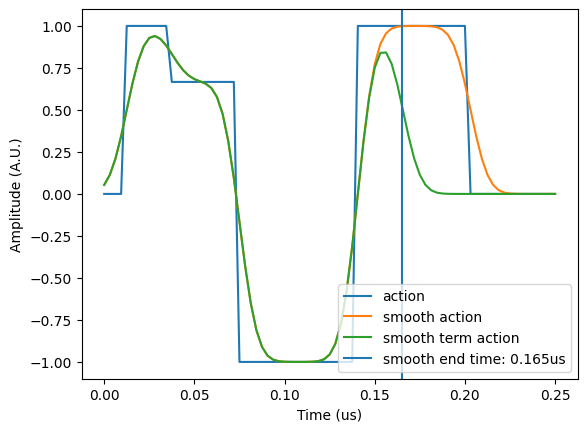

In [12]:
def smoother(action):
    return jnp.convolve(action, gauss_kernel, mode="same")

num_actions = 81
ts_action = jnp.linspace(0., 0.25, num_actions)

amp_1 = 1.
amp_2 = 2/3
amp_3 = -1.0
amp_4 = 1.0

t0 = 0.01
t1 = 0.035
t2 = 0.075
t3 = 0.14
t4 = 0.2
t_end = 0.165

act = amp_1 * jnp.heaviside(t1 - ts_action, 1.0) * jnp.heaviside(ts_action - t0, 1.0)
act += amp_2 * (jnp.heaviside(t2 - ts_action, 1.0) - jnp.heaviside(t1 - ts_action, 1.0))
act += amp_3 * (jnp.heaviside(t3 - ts_action, 1.0) - jnp.heaviside(t2 - ts_action, 1.0))
act += amp_4 * (jnp.heaviside(t4 - ts_action, 1.0) - jnp.heaviside(t3 - ts_action, 1.0))
term_action = act * jnp.heaviside(t_end - ts_action, 0.0)

smooth_action = smoother(act)
smooth_term_action = smoother(term_action)

plt.plot(ts_action, act, label='action')
plt.plot(ts_action, smooth_action, label='smooth action')
plt.plot(ts_action, smooth_term_action, label='smooth term action')
plt.axvline(x=t_end, label=f'smooth end time: {int(1e3*t_end) / 1e3}us')
plt.xlabel('Time (us)')
plt.ylabel('Amplitude (A.U.)')
plt.legend()
plt.show()

In [10]:
action_1 = smooth_action * env.a0 * env.mu
action_2 = smooth_term_action * env.a0 * env.mu

batched_action_1 = jnp.tile(action_1, (batchsize, 1))
batched_action_2 = jnp.tile(action_2, (batchsize, 1))

batched_res_1 = env.batched_results(batched_action_1)
(
    max_pf,
    max_photons,
    photon_reset_time_1,
    pulse_end_times,
    max_pf_times_1,
    smoothness_vals,
    b_pf,
    b_higher_photons_1,
    photon_reset_penalty_1
) = env.batched_extract_values(batched_res_1, batched_action_1)

reward_1, _ = env.batched_reward_and_state(
    batched_res_1,
    batched_action_1
)

print(max_pf_times_1[0])
print(photon_reset_time_1[0])
print(reward_1[0])

###

batched_res_2 = env.batched_results(batched_action_2)
(
    max_pf,
    max_photons,
    photon_reset_time_2,
    pulse_end_times,
    max_pf_times_2,
    smoothness_vals,
    b_pf,
    b_higher_photons_2,
    photon_reset_penalty_2
) = env.batched_extract_values(batched_res_2, batched_action_2)

reward_2, _ = env.batched_reward_and_state(
    batched_res_2,
    batched_action_2
)

print(max_pf_times_2[0])
print(photon_reset_time_2[0])
print(reward_2[0])

0.09305555555555556
0.1638888888888889
-179.11135940713189
0.09305555555555556
0.16805555555555557
20.846973926201446


0.008156907092598049
238
0.008156907092598049
238
0.0013596735910637444
359
0.0031285761525041015
299
31.688029930685886


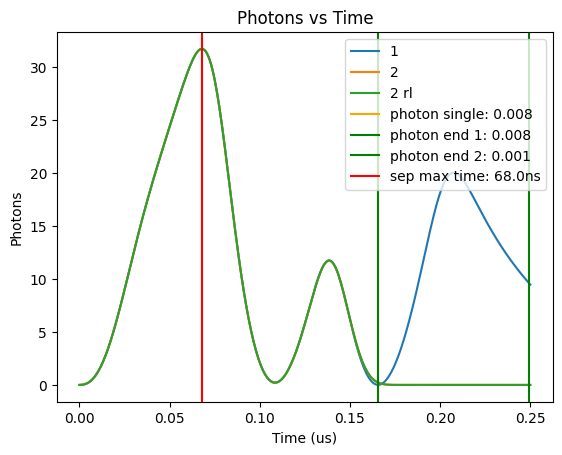

In [11]:
single_photon = b_higher_photons_2[0]

single_res_1 = batched_res_1[0]
g_real_1, g_imag_1, e_real_1, e_imag_1 = single_res_1.T
single_sep_1 = jnp.sqrt((g_real_1 - g_imag_1) ** 2 + (e_real_1 - e_imag_1) ** 2)

single_photon_1 = g_real_1 ** 2 + g_imag_1 ** 2

single_res_2 = batched_res_2[0]
g_real_2, g_imag_2, e_real_2, e_imag_2 = single_res_2.T
single_photon_2 = g_real_2 ** 2 + g_imag_2 ** 2
single_sep_2 = jnp.sqrt((g_real_2 - g_imag_2) ** 2 + (e_real_2 - e_imag_2) ** 2)

ext = 50
ext_15 = 300
ext_2 = -1

min_photon_1 = jnp.min(single_photon_1[ext:ext_2])
argmin_1 = jnp.argmin(single_photon_1[ext:ext_2]) + ext

min_photon_2_1 = jnp.min(single_photon_1[ext:ext_15])
argmin_2_1 = jnp.argmin(single_photon_1[ext:ext_15]) + ext

argmax_1 = jnp.argmax(single_sep_1)

print(min_photon_1)
print(argmin_1)

print(min_photon_2_1)
print(argmin_2_1)

min_photon_2 = jnp.min(single_photon_2[ext:ext_2])
argmin_2 = jnp.argmin(single_photon_2[ext:ext_2]) + ext

min_photon_2_2 = jnp.min(single_photon_2[ext:ext_15])
argmin_2_2 = jnp.argmin(single_photon_2[ext:ext_15]) + ext

argmax_2 = jnp.argmax(single_sep_2)

print(min_photon_2)
print(argmin_2)

print(min_photon_2_2)
print(argmin_2_2)

print(jnp.max(single_photon))

plt.plot(env.ts_sim, single_photon_1, label='1')
plt.plot(env.ts_sim, single_photon_2, label='2')
plt.plot(env.ts_sim, single_photon, label='2 rl')
plt.axvline(x=env.ts_sim[argmin_2_1], label=f'photon single: {int(1e3*min_photon_2_1)/1e3}', color='orange')
plt.axvline(x=env.ts_sim[argmin_1], label=f'photon end 1: {int(1e3*min_photon_1)/1e3}', color='green')
plt.axvline(x=env.ts_sim[argmin_2], label=f'photon end 2: {int(1e3*min_photon_2)/1e3}', color='green')
plt.axvline(x=env.ts_sim[argmax_1], label=f'sep max time: {int(1e4*env.ts_sim[argmax_1])/1e1}ns', color='red')
plt.xlabel('Time (us)')
plt.ylabel('Photons')
plt.title('Photons vs Time')
plt.legend()
plt.show()

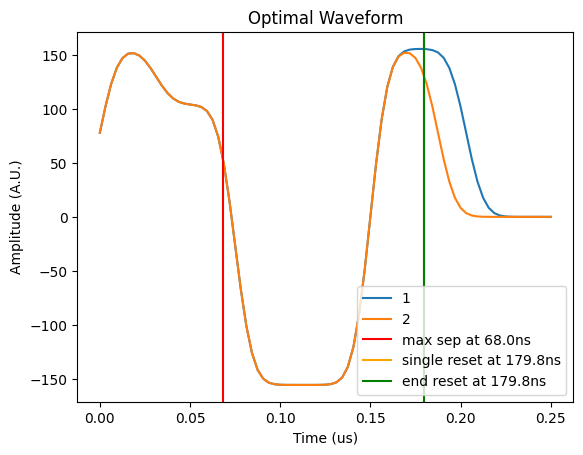

In [71]:
plt.plot(env.ts_action, action_1, label='1')
plt.plot(env.ts_action, action_2, label='2')
plt.axvline(x=env.ts_sim[argmax_1], label=f'max sep at {int(1e4*env.ts_sim[argmax_1])/1e1}ns', color='red')
plt.axvline(x=env.ts_sim[argmin_2_1], label=f'single reset at {int(1e4*env.ts_sim[argmin_2_1])/1e1}ns', color='orange')
plt.axvline(x=env.ts_sim[argmin_1], label=f'end reset at {int(1e4*env.ts_sim[argmin_1])/1e1}ns', color='green')
plt.xlabel('Time (us)')
plt.ylabel('Amplitude (A.U.)')
plt.title('Optimal Waveform')
plt.legend()
plt.show()

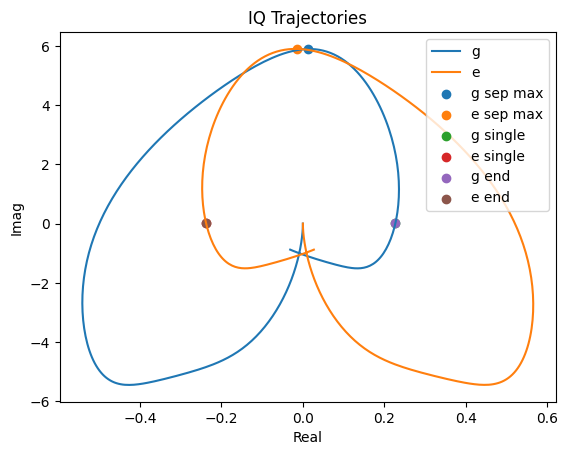

In [21]:
plt.plot(g_real, g_imag, label='g')
plt.plot(e_real, e_imag, label='e')
plt.scatter(g_real[argmax], g_imag[argmax], label='g sep max')
plt.scatter(e_real[argmax], e_imag[argmax], label='e sep max')
plt.scatter(g_real[argmin_2], g_imag[argmin_2], label='g single')
plt.scatter(e_real[argmin_2], e_imag[argmin_2], label='e single')
plt.scatter(g_real[argmin], g_imag[argmin], label='g end')
plt.scatter(e_real[argmin], e_imag[argmin], label='e end')
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title('IQ Trajectories')
plt.legend()
plt.show()